<a href="https://colab.research.google.com/github/mini3713/mini3713/blob/main/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D%2B%EB%94%A5%EB%9F%AC%EB%8B%9D/XGBoost_04_From_Gradient_Boosting_to_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**4 그레이디언트 부스팅에서 XGBoost까지**
=======================
그레이디언트 부스팅의 작동방식을 이해하고 실습

4.1 배깅에서 부스팅까지
====================
> * 랜덤포레스트와 다르게 **부스팅**은 개별트리의 실수로부터 학습 
> * 이전 트리의 오차를 기반으로 새로운 트리를 훈련

> ### 에이다부스트 소개
> * 초기 부스팅 모델이며, 새로운 트리가 이전 트리의 오차를 기반으로 가중치를 조정 
> * 오류 샘플의 가중치를 높여 잘못된 예측에 더 많은 주의를 기울임 
> * **약한 학습기**인 기반 모델을 수백번의 반복을 통해 **강력한 학습기**로 만들어줌 
>  * 기반모델이 너무 강하면 학습과정이 제한되어 부스팅 모델의 전략을 약화시킴 

> ### 그레이디언트 부스팅의 특징
> * 에이다부스트와는 다르게 이전 트리의 예측 오차를 기반으로 **완전히 새로운 트리**를 훈련
> * 새로운 트리는 올바르게 예측된 값에는 영향을 받지 않음 
> * 오차를 계산하기 위해 예측과 실제값 사이의 차이인 **잔차**(residual)를 활용
> * 그레이디언트 부스팅은 각 트리 예측 값을 더해서 모델 평가에 사용 

4.2 그레이디언트 부스팅 작동 방식
====================

> ### 잔차
> * 통계학에서는 일반적으로 선형 회귀모델이 데이터에 얼마나 잘 맞는지 평가하기 위해 사용됨 
> * 선형회귀의 목적은 잔차의 제곱을 최소화하는 것 
> * 그레이디언트 부스팅 알고리즘을 직접 구현해보기 위해 각 트리의 잔차를 계산하고 이 잔차에 새로운 모델을 훈련

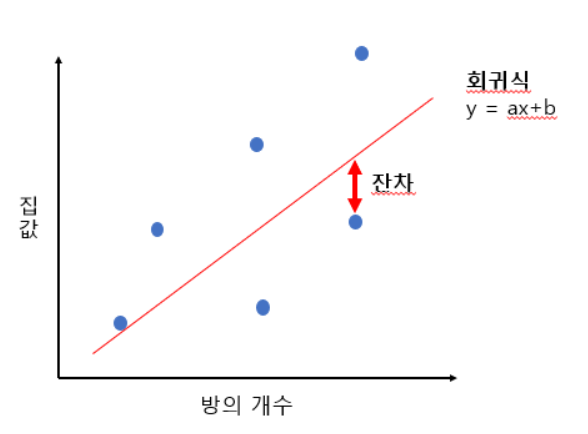

출처 : https://blog.naver.com/PostView.nhn?blogId=winddori2002&logNo=221676654945

> ### 결정트리로 그레이디언트 부스팅 모델 만들기

In [ ]:
# 자전거 대여 데이터셋 활용
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb

In [ ]:
df_bikes = pd.read_csv('/content/bike_rentals_cleaned.csv')
df_bikes.head()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,1.0,0.0,1.0,0.0,6.0,0.0,2,0.344167,0.363625,0.805833,0.160446,985
1,2,1.0,0.0,1.0,0.0,0.0,0.0,2,0.363478,0.353739,0.696087,0.248539,801
2,3,1.0,0.0,1.0,0.0,1.0,1.0,1,0.196364,0.189405,0.437273,0.248309,1349
3,4,1.0,0.0,1.0,0.0,2.0,1.0,1,0.200000,0.212122,0.590435,0.160296,1562
4,5,1.0,0.0,1.0,0.0,3.0,1.0,1,0.226957,0.229270,0.436957,0.186900,1600


In [ ]:
X_bikes = df_bikes.iloc[:,:-1]
y_bikes = df_bikes.iloc[:, -1]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_bikes, y_bikes, random_state=2)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
tree_1 = DecisionTreeRegressor(max_depth=2, random_state=2)
tree_1.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=2, random_state=2)

In [ ]:
# 훈련세트에 대한 예측을 생성
# 잔차를 계산하기 위해서, 훈련단계에서 예측과 타깃을 비교해야 함 
# 모델의 테스트 단계는 모든 트리를 구성한 후 마지막 순서 
y_train_pred = tree_1.predict(X_train)
# 잔차 계산
y2_train = y_train - y_train_pred

In [ ]:
# 잔차를 기반으로 새로운 트리를 훈련 
tree_2 = DecisionTreeRegressor(max_depth=2, random_state=2)
tree_2.fit(X_train, y2_train)

DecisionTreeRegressor(max_depth=2, random_state=2)

In [ ]:
# 앞단계를 반복
y2_train_pred = tree_2.predict(X_train)
y3_train = y2_train - y2_train_pred
tree_3 = DecisionTreeRegressor(max_depth=2, random_state=2)
tree_3.fit(X_train, y3_train)
# 강력한 학습기를 만들기 위해, 이 과정이 수십, 수백, 수천개의 트리까지 계속될 수 있음 

DecisionTreeRegressor(max_depth=2, random_state=2)

In [ ]:
y1_pred = tree_1.predict(X_test)
y2_pred = tree_2.predict(X_test)
y3_pred = tree_3.predict(X_test)
# 예측을 합해준다
# 잔차는 음수값도 존재하기 때문에 예측값이 음수값이 될 수 있다
# 따라서 예측을 모두 더하면 타깃에 더 가까운 결과를 만들게 된다 
y_pred = y1_pred + y2_pred + y3_pred
# 평균 제곱근 오차(RMSE)를 계산
from sklearn.metrics import mean_squared_error as MSE
MSE(y_test, y_pred)**0.5

911.0479538776444

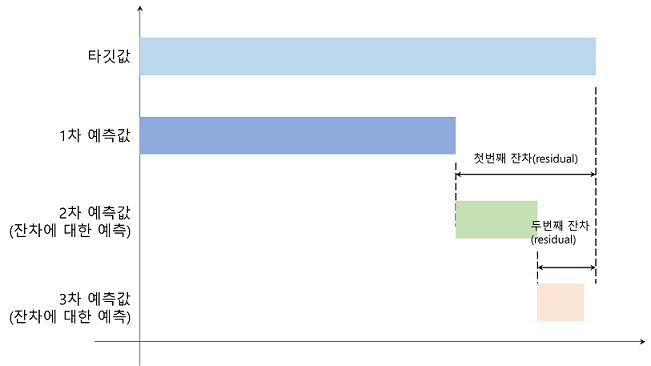

> ### 사이킷런으로 그레이디언트 부스팅 모델 만들기

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(max_depth=2, n_estimators=3, random_state=2, learning_rate=1.0)

In [ ]:
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
MSE(y_test, y_pred)**0.5

911.0479538776439

In [ ]:
# 트리 개수를 30개로 증가
gbr = GradientBoostingRegressor(max_depth=2, n_estimators=30, random_state=2, learning_rate=1.0)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
MSE(y_test, y_pred)**0.5

857.1072323426944

In [ ]:
# 트리 개수를 300개로 증가
gbr = GradientBoostingRegressor(max_depth=2, n_estimators=300, random_state=2, learning_rate=1.0)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
MSE(y_test, y_pred)**0.5

936.3617413678853

In [ ]:
# learning_rate 매개변수를 제거하면?
gbr = GradientBoostingRegressor(max_depth=2, n_estimators=300, random_state=2)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
MSE(y_test, y_pred)**0.5

653.7456840231495

4.3 그레이디언트 부스팅 매개변수 튜닝
====================

> ### learning_rate
> * 모델에 큰 영향을 끼치지 않도록 개별트리의 기여를 줄여주는 매개변수이며, **축소**(shirinkage)라고도 부른다
> * 이 매개변수를 조정하지 않고 기본 학습기의 오차를 기반으로 앙상블을 만들면 처음 추가된 트리의 영향이 너무 크게 된다
> * 따라서 트리개수인 n_estimators를 늘리면 learning_rate는 줄어야 한다
> * learning_rate가 0.1이라면 트리의 영향을 10%로 줄인다는 뜻이다

In [ ]:
learning_rate_values = [0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 1.0]

In [ ]:
# for문으로 모델을 만들고 점수를 출력
for value in learning_rate_values:
  gbr = GradientBoostingRegressor(max_depth=2, n_estimators=300, random_state=2, learning_rate=value)
  gbr.fit(X_train, y_train)
  y_pred = gbr.predict(X_test)
  rmse = MSE(y_test, y_pred)**0.5
  print('학습률:', value, ', 점수:', rmse)

학습률: 0.001 , 점수: 1633.0261400367258
학습률: 0.01 , 점수: 831.5430182728547
학습률: 0.05 , 점수: 685.0192988749717
학습률: 0.1 , 점수: 653.7456840231495
학습률: 0.15 , 점수: 687.666134269379
학습률: 0.2 , 점수: 664.312804425697
학습률: 0.3 , 점수: 689.4190385930236
학습률: 0.5 , 점수: 693.8856905068778
학습률: 1.0 , 점수: 936.3617413678853


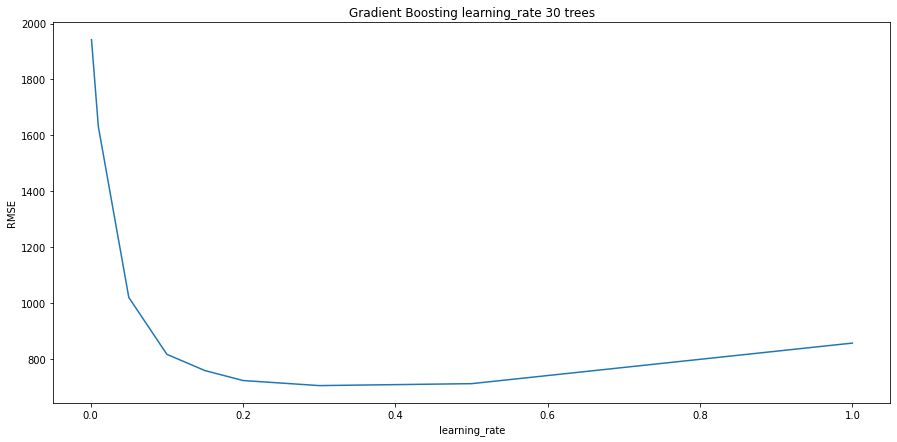

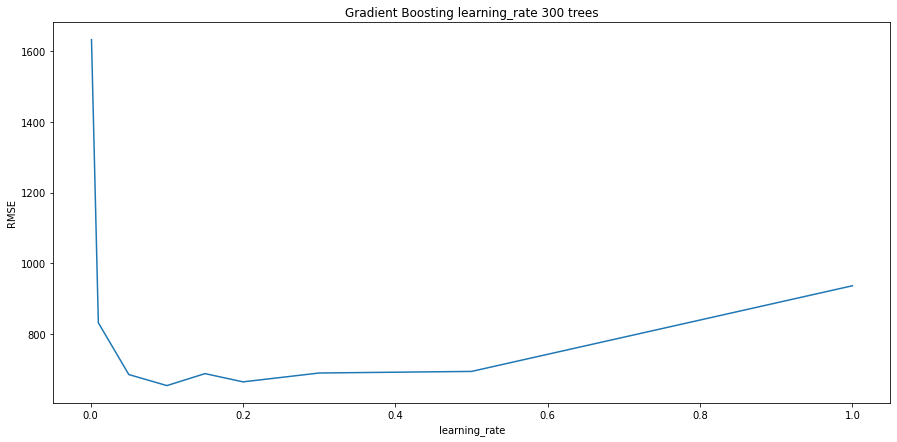

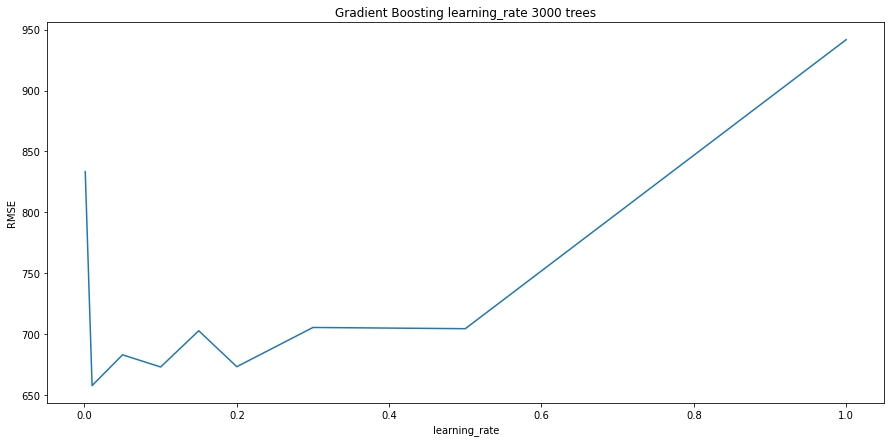

In [ ]:
# n_estimators가 30, 300, 3000일 경우
from sklearn.metrics import mean_squared_error
for est in [30, 300, 3000]:
    rmse_scores = []
    for value in learning_rate_values:
        gbr = GradientBoostingRegressor(max_depth=2, n_estimators=est, 
                                        random_state=2, learning_rate=value)
        gbr.fit(X_train, y_train)
        y_pred = gbr.predict(X_test)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        rmse_scores.append(rmse)
    plt.figure(figsize=(15,7))
    plt.plot(learning_rate_values, rmse_scores)
    plt.xlabel('learning_rate')
    plt.ylabel('RMSE')
    plt.title('Gradient Boosting learning_rate {} trees'.format(est))
    plt.show()

> ### 기본 학습기
> * 그레이디언트 부스팅 회귀 모델의 기본 학습기는 **결정 트리**

In [ ]:
# 하나의 예로 max_depth
depths = [None, 1, 2, 3, 4]
for depth in depths:
  gbr = GradientBoostingRegressor(max_depth=depth, n_estimators=300, random_state=2)
  gbr.fit(X_train, y_train)
  y_pred = gbr.predict(X_test)
  rmse = MSE(y_test, y_pred)**0.5
  print('최대깊이:', depth, ', 점수:', rmse)

최대깊이: None , 점수: 869.2788645118395
최대깊이: 1 , 점수: 707.8261886858736
최대깊이: 2 , 점수: 653.7456840231495
최대깊이: 3 , 점수: 646.4045923317708
최대깊이: 4 , 점수: 663.048387855927


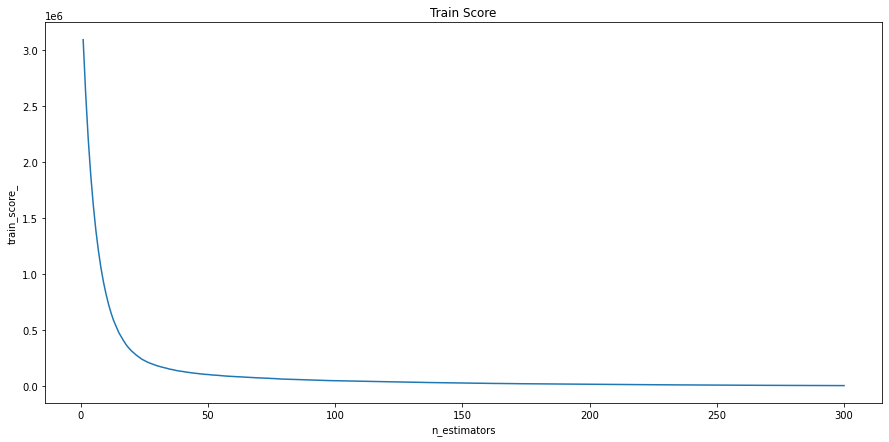

In [ ]:
# 손실 그래프 그리기
# 손실함수 값은 train_score_ 속성에 저장
plt.figure(figsize=(15,7))
plt.plot(range(1, 301), gbr.train_score_)
plt.xlabel('n_estimators')
plt.ylabel('train_score_')
plt.title('Train Score')
plt.show()

> ### subsample
> * 기본 학습기에 사용될 샘플의 비율을 지정
> * subsample=0.8은 80%의 훈련세트만 사용한다는 의미
> * subsample이 1보다 작은 모델을 **확률적 그레이디언트 부스팅**이라고 하는데, 이 말은 모델에 무작위성이 주입된다는 뜻

In [ ]:
samples = [1, 0.9, 0.8, 0.7, 0.6, 0.5]
for sample in samples:
  gbr = GradientBoostingRegressor(max_depth=3, n_estimators=300, subsample=sample, random_state=2)
  gbr.fit(X_train, y_train)
  y_pred = gbr.predict(X_test)
  rmse = MSE(y_test, y_pred)**0.5
  print('subsample:', sample, ', 점수:', rmse)

subsample: 1 , 점수: 646.4045923317708
subsample: 0.9 , 점수: 620.1819001443569
subsample: 0.8 , 점수: 617.2355650565677
subsample: 0.7 , 점수: 612.9879156983139
subsample: 0.6 , 점수: 622.6385116402317
subsample: 0.5 , 점수: 626.9974073227554


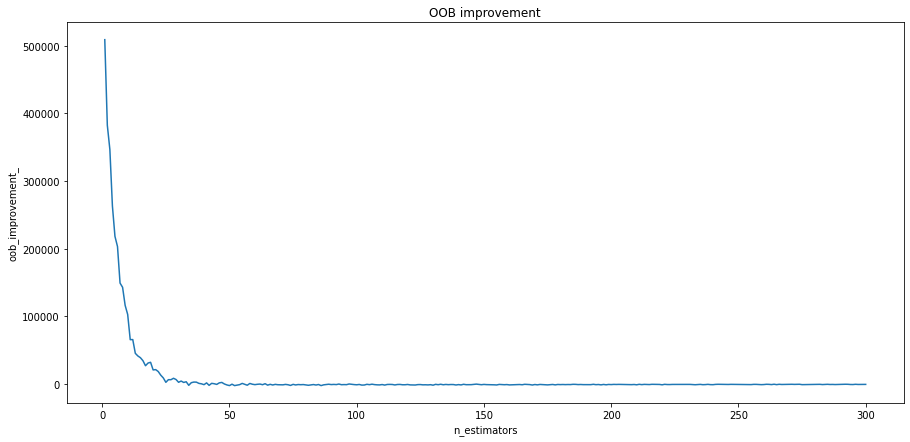

In [ ]:
# subsample이 1.0보다 작을 때 OOB 점수를 계산할 수 있다
# 그레이디언트 부스팅 모델은 oob_improvement_ 속성에 이 값을 기록한다
plt.figure(figsize=(15,7))
plt.plot(range(1, 301), gbr.oob_improvement_)
plt.xlabel('n_estimators')
plt.ylabel('oob_improvement_')
plt.title('OOB improvement')
plt.show()

> ### RandomizedSearchCV

In [ ]:
params = {'subsample':[0.65, 0.7, 0.75],
          'n_estimators':[300, 500, 1000],
          'learning_rate': [0.05, 0.075, 0.1]}
from sklearn.model_selection import RandomizedSearchCV
gbr = GradientBoostingRegressor(max_depth=3, random_state=2)
rand_reg = RandomizedSearchCV(gbr, params, n_iter=10, scoring='neg_mean_squared_error', cv=5, n_jobs=-1, random_state=2)

In [ ]:
rand_reg.fit(X_train, y_train)
best_model = rand_reg.best_estimator_
best_params = rand_reg.best_params_
print("최상의 매개변수:", best_params)
best_score = np.sqrt(-rand_reg.best_score_)
print("훈련 점수: {:.3f}".format(best_score))
y_pred = best_model.predict(X_test)
rmse_test = MSE(y_test, y_pred)**0.5
print("테스트세트 점수: {:.3f}".format(rmse_test))

최상의 매개변수: {'subsample': 0.65, 'n_estimators': 300, 'learning_rate': 0.05}
훈련 점수: 636.200
테스트세트 점수: 625.985


> ### XGBoost
> * XGBoost의 learning_rate 매개변수는 eta 이다 

In [ ]:
from xgboost import XGBRegressor
xg_reg = XGBRegressor(max_depth=3, n_estimators=1600, eta=0.02, subsample=0.75, random_state=2)
xg_reg.fit(X_train, y_train)
y_pred = xg_reg.predict(X_test)
MSE(y_test, y_pred)**0.5

[02:10:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


584.6690439795171

4.4 빅데이터 다루기
====================
**그레이디언트부스팅** VS **XGBoost**

> ### 외계행성 찾기
> 외계행성 데이터셋으로 별이 외계행성을 가지고 있는지 여부에 대해 예측

In [ ]:
# 데이터셋 전처리
df = pd.read_csv('/content/exoplanets.csv')
df.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5087 entries, 0 to 5086
Columns: 3198 entries, LABEL to FLUX.3197
dtypes: float64(3197), int64(1)
memory usage: 124.1 MB


In [ ]:
df.isnull().sum().sum()

0

In [ ]:
X = df.iloc[:, 1:]
y = df.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [ ]:
# 속도 비교
import time
start = time.time()
gbr = GradientBoostingClassifier(n_estimators=100, max_depth=2, random_state=2)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
score = accuracy_score(y_pred, y_test)
print('점수: ' + str(score))
end = time.time()
elapsed = end - start
print('실행시간: ' + str(elapsed) + ' 초')

점수: 0.9874213836477987
실행시간: 268.9889304637909 초


In [ ]:
start = time.time()
xg_reg = XGBClassifier(n_estimators=100, max_depth=2)
xg_reg.fit(X_train, y_train)
y_pred = xg_reg.predict(X_test)
score = accuracy_score(y_pred, y_test)
print('점수: ' + str(score))
end = time.time()
elapsed = end - start
print('실행시간: ' + str(elapsed) + ' 초')

점수: 0.9913522012578616
실행시간: 50.00658917427063 초
